In [41]:
from src.pyha_visualization import local_line_graph
from src.TweetyNetAudio import load_wav
import pandas as pd
import numpy as np
import os
import sys

In [42]:
def kaliedoscope_format(df, filename):
    filtered_df = df[df["file"] == filename]
    print(filtered_df["pred"])
    print("HERE")
    print(len(filtered_df))
    if filtered_df.empty == True:
        print("THERE")
        print(f"file: {filename} was not in test set")
        return filtered_df
    sorted_filtered_df = filtered_df.sort_values("overall frame number")
    #print(sum(sorted_filtered_df["pred"]))
    time_bin_seconds = sorted_filtered_df.iloc[1]["temporal_frame_start_times"]
    #print(time_bin_seconds)
    zero_sorted_filtered_df = sorted_filtered_df[sorted_filtered_df["pred"] == 0]
    offset = zero_sorted_filtered_df["temporal_frame_start_times"]
    duration = zero_sorted_filtered_df["temporal_frame_start_times"].diff().shift(-1)
    intermediary_df = pd.DataFrame({"OFFSET": offset, "DURATION": duration})
    kaliedoscope_df = []
    if offset.iloc[0] != 0:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [0], "DURATION": [offset.iloc[0]]}))
    kaliedoscope_df.append(intermediary_df[intermediary_df["DURATION"] >= 2*time_bin_seconds])
    if offset.iloc[-1] < sorted_filtered_df.iloc[-1]["temporal_frame_start_times"]:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [offset.iloc[-1]], "DURATION": [sorted_filtered_df.iloc[-1]["temporal_frame_start_times"] + 
                                sorted_filtered_df.iloc[1]["temporal_frame_start_times"]]}))
    kaliedoscope_df = pd.concat(kaliedoscope_df)
    kaliedoscope_df = kaliedoscope_df.reset_index(drop=True)
    return kaliedoscope_df
    

In [43]:
def create_visualization(filename, csv):
    automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
    premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b", csv)
    Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", filename)
    SR, SIGNAL = load_wav(Wav_path)
    if automated_annotations_path == "":
        automated_df = pd.DataFrame()
    else:
        automated_df = pd.read_csv(automated_annotations_path)
    automated_df = kaliedoscope_format(automated_df, filename)
    print(automated_df)

    premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
    premade_annotations_label = "Bird"
    print(premade_annotations_df)
    # change local scores to what tweetynet returns.
    log_scale = True
    save_fig = False
    normalize_local_scores = False
    local_line_graph([0] * 216,
        Wav_path,
        SR,
        samples=SIGNAL,
        automated_df= automated_df,
        premade_annotations_df=premade_annotations_df,
        premade_annotations_label=premade_annotations_label,
        log_scale=log_scale,
        save_fig=save_fig,
        normalize_local_scores=normalize_local_scores)

6696    0
6697    0
6698    0
6699    0
6700    0
       ..
6907    0
6908    0
6909    0
6910    0
6911    0
Name: pred, Length: 216, dtype: int64
HERE
216
Empty DataFrame
Columns: [OFFSET, DURATION]
Index: []
      OFFSET  DURATION          TAG
0   0.000000  0.043537  Sylatr_call
1   0.301859  0.034830  Sylatr_call
2   0.502132  0.031927  Sylatr_call
3   0.641451  0.031927  Sylatr_call
4   0.818503  0.029025  Sylatr_call
5   0.981043  0.043537  Sylatr_call
6   1.190023  0.046440  Sylatr_call
7   1.332245  0.034830  Sylatr_call
8   1.486077  0.029025  Sylatr_call
9   1.689252  0.026122  Sylatr_call
10  2.194286  0.046440  Sylatr_call
11  2.394558  0.034830  Sylatr_call
12  2.638367  0.029025  Sylatr_call
13  2.795102  0.031927  Sylatr_call
14  3.018594  0.034830  Sylatr_call
15  3.288526  0.043537  Sylatr_call
16  3.506213  0.037732  Sylatr_call
17  3.662948  0.031927  Sylatr_call
18  3.813878  0.037732  Sylatr_call
19  4.043175  0.026122  Sylatr_call
20  4.295692  0.023220  Sylatr_ca

e:\Q1-Project-Code\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


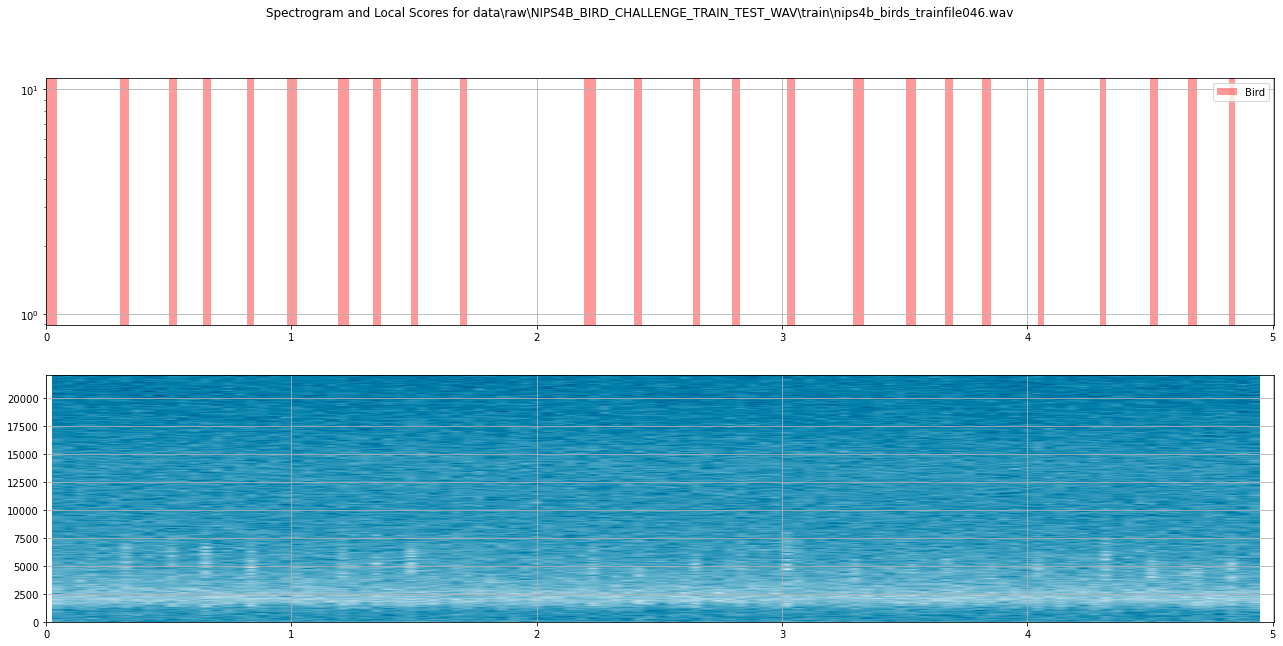

In [44]:
folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train")
csv_folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b")
files = os.listdir(folder)
csvs = os.listdir(csv_folder)
print(files[45])
create_visualization(files[45], csvs[45])

#use the evaluation_on_data.csv for this.

0      0
1      0
2      0
3      0
4      0
      ..
211    0
212    0
213    0
214    0
215    0
Name: pred, Length: 216, dtype: int64
HERE
216
     OFFSET  DURATION
0  0.092880  0.046440
1  0.208980  0.255420
2  1.555737  0.441179
3  2.368435  0.162540
4  3.668753  0.185760
     OFFSET  DURATION          TAG
0  0.095782  0.044989      Unknown
1  0.220590  0.243810  Butbut_call
2  0.592109  0.023220  Erirub_call
3  0.825760  0.026122  Erirub_call
4  1.584762  0.400544  Butbut_call
5  2.265397  0.020317  Erirub_call
6  2.356825  0.201723  Parate_call
7  2.478730  0.046440  Erirub_call
8  3.601995  0.236553      Unknown


e:\Q1-Project-Code\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


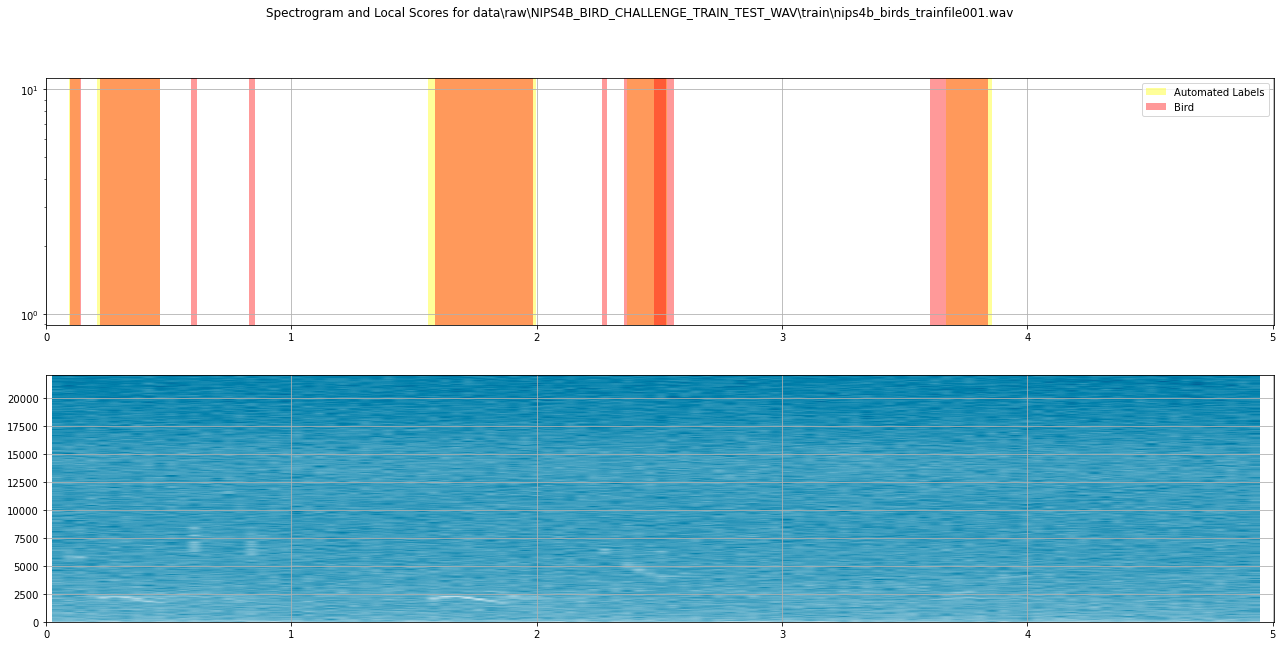

In [45]:
automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b","annotation_train001.csv")
Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", "nips4b_birds_trainfile001.wav")
SR, SIGNAL = load_wav(Wav_path)
if automated_annotations_path == "":
    automated_df = pd.DataFrame()
else:
    automated_df = pd.read_csv(automated_annotations_path)
#print(automated_df.columns)
#add testing for kaliedoscope format
#automated_df.loc[0:50,"pred"] = 1
#automated_df.loc[100:150,"pred"] = 1
#automated_df.loc[175:198,"pred"] = 1
#automated_df.loc[200:215,"pred"] = 1
# Need to convert this df to kaliedoscope format
automated_df = kaliedoscope_format(automated_df, "nips4b_birds_trainfile001.wav")
print(automated_df)

premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
premade_annotations_label = "Bird"
print(premade_annotations_df)
# change local scores to what tweetynet returns.
log_scale = True
save_fig = False
normalize_local_scores = False
local_line_graph([0] * 216,
    Wav_path,
    SR,
    samples=SIGNAL,
    automated_df= automated_df,
    premade_annotations_df=premade_annotations_df,
    premade_annotations_label=premade_annotations_label,
    log_scale=log_scale,
    save_fig=save_fig,
    normalize_local_scores=normalize_local_scores)